In [1]:

import matplotlib.pyplot as plt
import glob, sys, os, re
import numpy as np
import json
import pandas as pd
import seaborn as sns
import plotly.express as px
from scipy import stats

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import plotly
plotly.offline.init_notebook_mode()

### Load data

In [2]:
df=pd.read_csv('recordings_current_clamp.csv', index_col=0)
df = df[(df['isValid']==1) & (df['protocol']=='current_clamp') & (df['age_group'].isin(['5-6 weeks', '7-11 weeks']))]
all_peak_df = pd.read_csv('evoked_AP_all_peaks.csv')

In [3]:
age_group_list = sorted(list(set(df['age_group'])))
age_group_list

['5-6 weeks', '7-11 weeks']

In [4]:
set(df['Line'])

{'JNJ008 (diff 07062021)',
 'JNJ008_PROX1 (diff 04112021)',
 'JNJ009 (diff 07062021)',
 'SND4652#2 (diff 15072021)',
 'SND4652#2_PROX1 (diff 15112021)'}

In [5]:
def plot_comparison(df, age_group_list, parameter, prxo1_split=None): 

    fig = make_subplots(rows=1, cols=2, subplot_titles=age_group_list)

    for k, ageGroup in enumerate(age_group_list): 
        subDF = df[df['age_group']==ageGroup]

        if prxo1_split: 
            fig.add_trace(go.Violin(x=subDF[subDF['Line'].str.contains('PROX1')]['type'],
                                y=subDF[subDF['Line'].str.contains('PROX1')][parameter],
                                box_visible=False,
                                meanline_visible=True, points='all', pointpos=0, 
                                name = 'PROX1',
                                side='negative',), 
                                row=1, col=k+1)

            fig.add_trace(go.Violin(x=subDF[~subDF['Line'].str.contains('PROX1')]['type'],
                                y=subDF[~subDF['Line'].str.contains('PROX1')][parameter],
                                name='Non PROX1',
                                box_visible=False,
                                meanline_visible=True, points='all', pointpos=0, 
                                side='positive',), 
                                row=1, col=k+1)
            
        else: 
            fig.add_trace(go.Violin(x=subDF['type'],
                                y=subDF[parameter],
                                box_visible=False,
                                meanline_visible=True, points='all', pointpos=0,
                                ), 
                                row=1, col=k+1)            
        
        fig.add_annotation(x=-.2, y=5,
                    text="N={}".format(subDF[subDF['type']=='Control'].shape[0]),
                    font_size=14, showarrow=False,arrowhead=0,  row=1,  col = k+1)

        fig.add_annotation(x=1.2, y=5,
                    text="N={}".format(subDF[subDF['type']=='SLC1A4'].shape[0]),
                    font_size=14, showarrow=False,arrowhead=0 , row=1,  col = k+1)

        (stat, p_val)= stats.ttest_ind(subDF[subDF['type']=='Control'][parameter].dropna(), 
                                       subDF[subDF['type']=='SLC1A4'][parameter].dropna())

        fig.add_annotation(x=0.5, y=5,
                    text="p-value={:.3f}".format(p_val),
                    font_size=14,
                    showarrow=False,
                    arrowhead=0, 
                    row=1,  col = k+1) 

        # fig.update_yaxes(range=[0, 90], row=1, col=k+1)

    fig.update_layout(height=600, width=1200,showlegend=False, violingap=0, violingroupgap=0,
        title={
            'text' : 'SLC1A4 vs. Contol (Age: '+ ageGroup +')<br>Parameter: '+parameter ,
            'x':0.5,
            'xanchor': 'center'   })
    return fig



## Total and Max Evoked AP

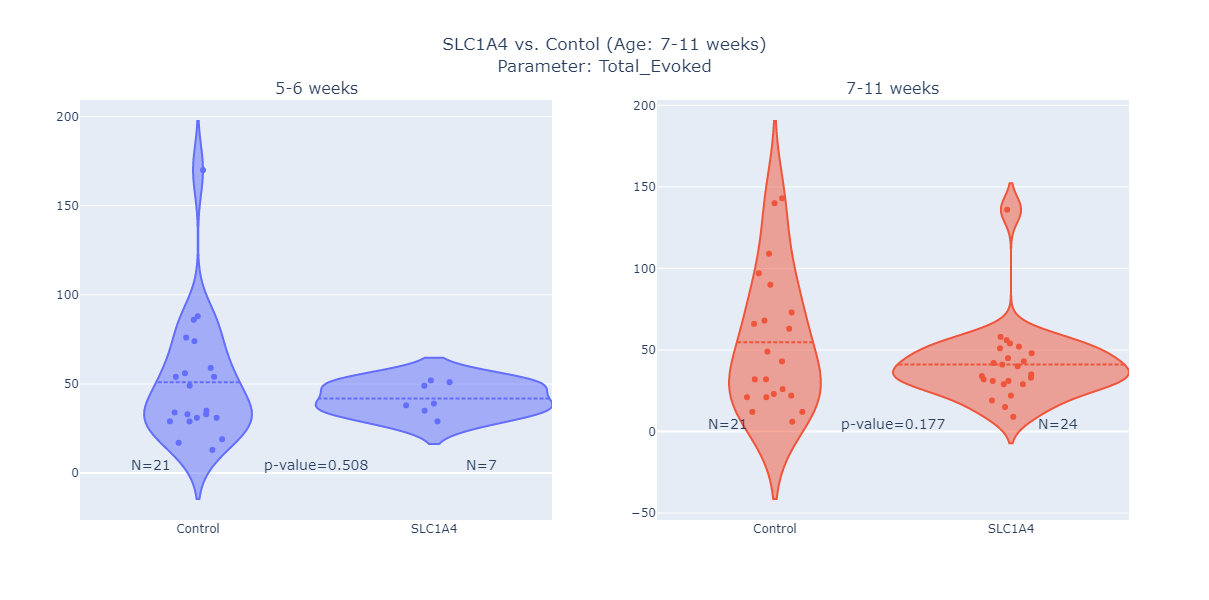

In [6]:
plot_comparison(df, age_group_list, parameter = 'Total_Evoked').show()

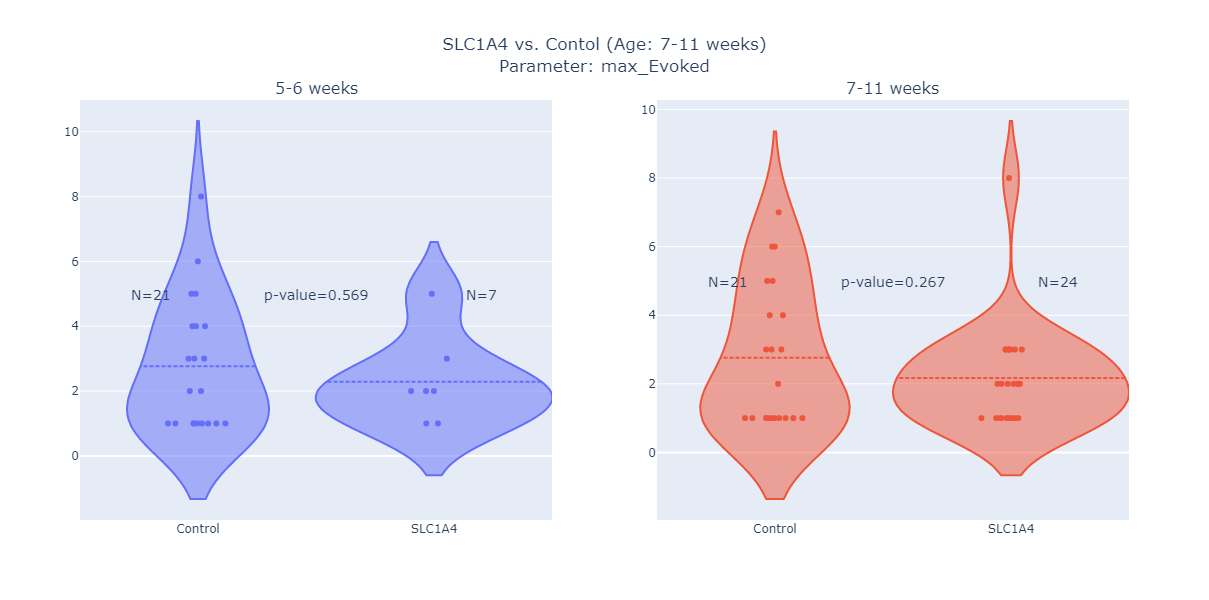

In [7]:
plot_comparison(df, age_group_list, parameter = 'max_Evoked').show()

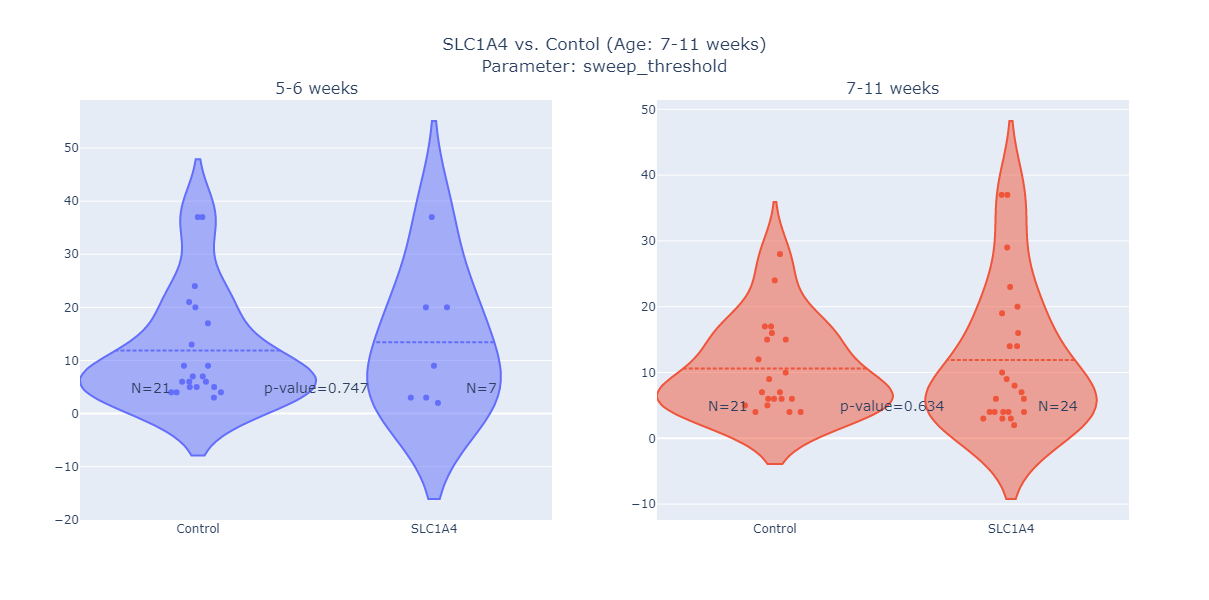

In [8]:
plot_comparison(df, age_group_list, parameter = 'sweep_threshold').show()

## Shape Analysis

In [9]:
shape_analysis_df = pd.merge_asof(pd.DataFrame(all_peak_df), df[['Line', 'age', 'age_group', 'type']], left_on='idx', right_index=True, )

In [10]:
shape_analysis_df.columns

Index(['Unnamed: 0', 'idx', 'sweep', 'evoked_AP', 'prominences', 'left_bases',
       'right_bases', 'widths', 'width_heights', 'left_ips', 'right_ips',
       'Line', 'age', 'age_group', 'type'],
      dtype='object')

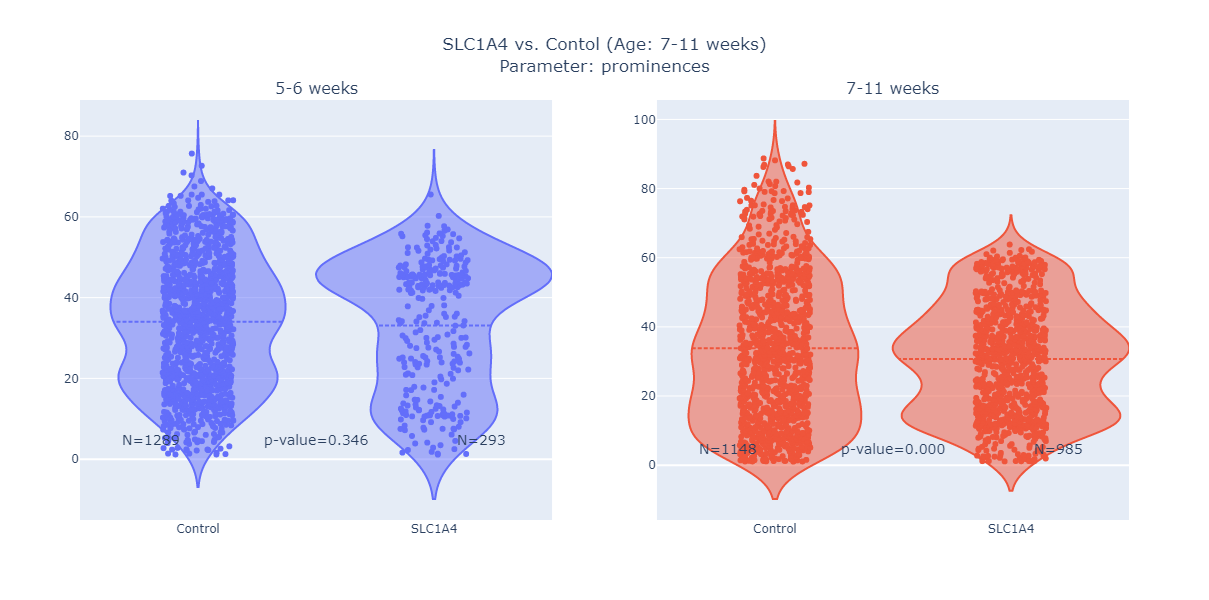

In [11]:
plot_comparison(shape_analysis_df, age_group_list, parameter = 'prominences').show()

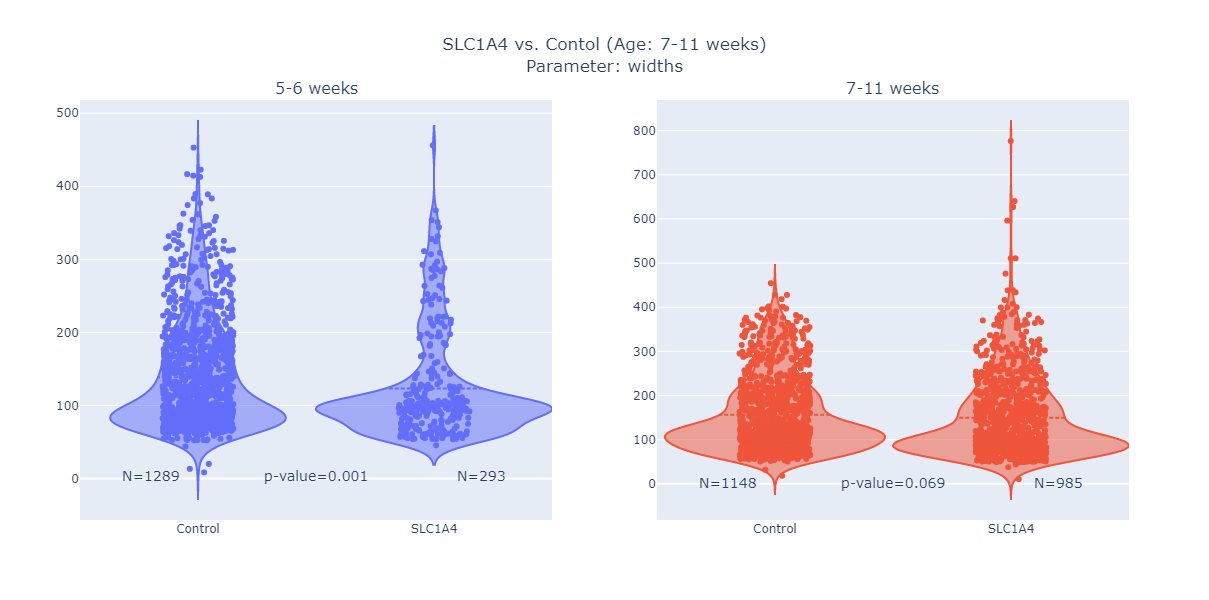

In [12]:
plot_comparison(shape_analysis_df, age_group_list, parameter = 'widths').show()

### Only the first AP 

In [13]:
first_AP_df = shape_analysis_df.loc[shape_analysis_df.groupby('idx').sweep.idxmin()]

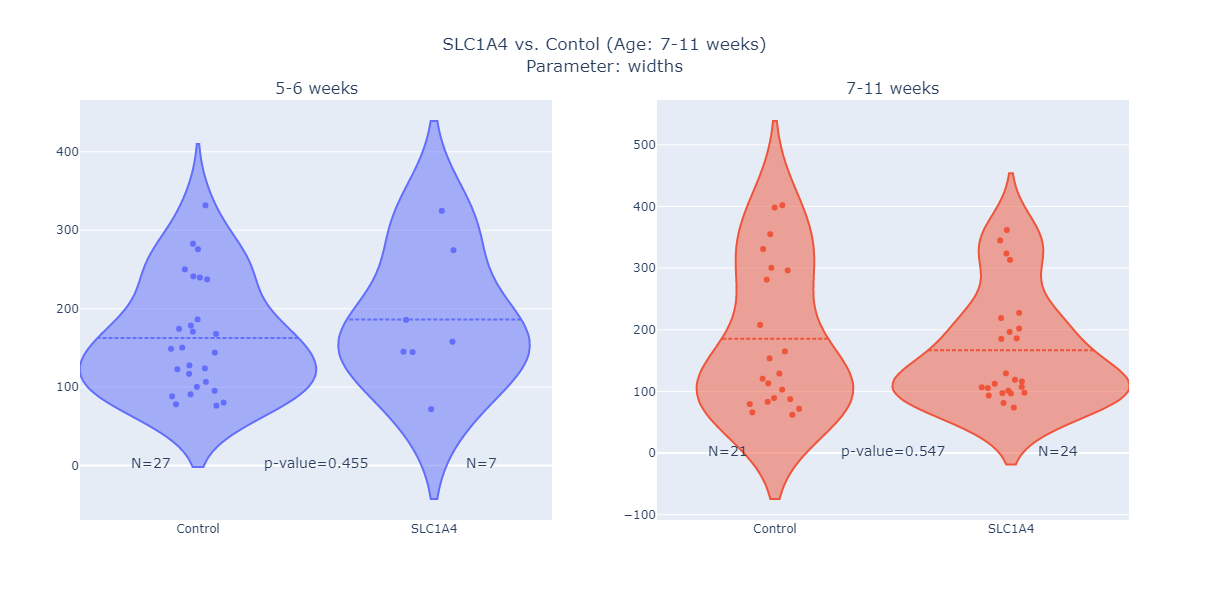

In [14]:
plot_comparison(first_AP_df, age_group_list, parameter = 'widths').show()

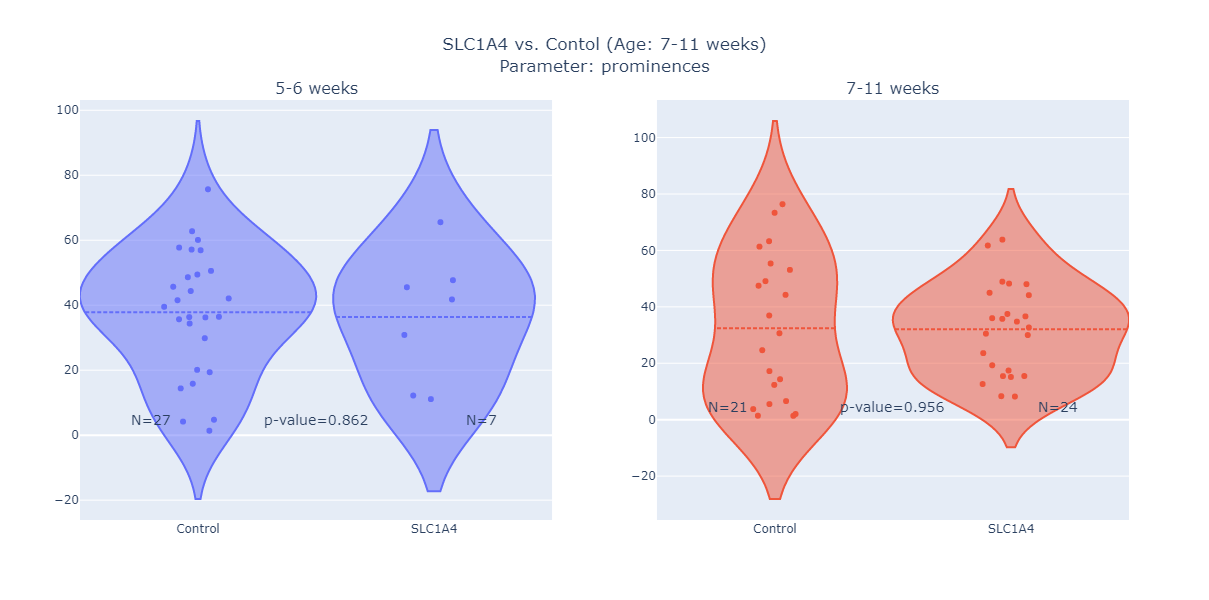

In [15]:
plot_comparison(first_AP_df, age_group_list, parameter = 'prominences').show()

## AP Shape Comparison 

In [16]:
def load_ap_shape_by(df, key, val): 
    joined_ap=[]
    for k, row in df[df[key]==val].iterrows(): 
        label = str((row['idx'], row['sweep'], round(row['evoked_AP'])))
        fname = r'ap_peaks\shape_analysis\ap_shape_{0}.txt'.format(label)
        ap = np.loadtxt(fname)
        joined_ap.append(ap)
    return np.vstack(joined_ap)

In [17]:
def plot_with_ci(data, method = 't', interval = 0.95, ax=None): 
    
    mean_val = data.mean(axis=1)
    n = data.shape[0]
    stdev = data.std()

    if method == 't':
        test_stat = stats.t.ppf((interval + 1)/2, n)
    elif method == 'z':
        test_stat = stats.norm.ppf((interval + 1)/2)

    ci =  test_stat * stdev / np.sqrt(n)
    if ax: 
        ax.plot(mean_val)
        ax.fill_between(np.arange(n), (mean_val-ci), (mean_val+ci), color='b', alpha=.1)
    else: 
        plt.plot(mean_val)
        plt.fill_between(np.arange(n), (mean_val-ci), (mean_val+ci), color='b', alpha=.1)       
        plt.show()

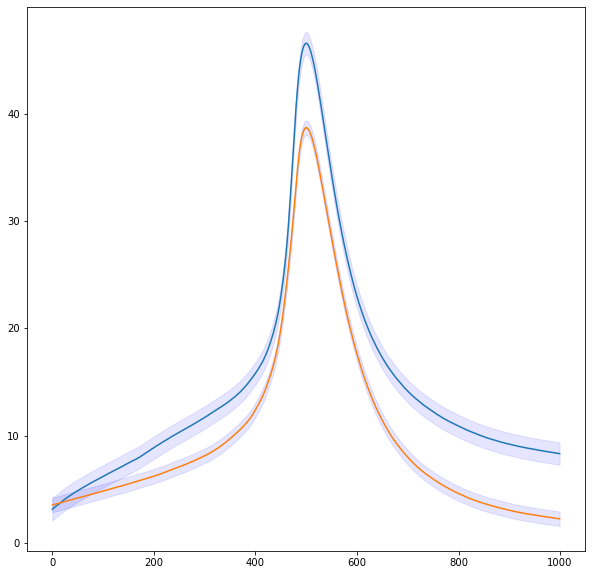

In [18]:
control_ap = load_ap_shape_by(first_AP_df, 'type', 'Control')
control_ap = (control_ap.T - control_ap.min(axis=1))
slc1a4_ap = load_ap_shape_by(first_AP_df, 'type', 'SLC1A4')
slc1a4_ap = slc1a4_ap.T - slc1a4_ap.min(axis=1)
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))

plot_with_ci(control_ap, ax=ax1)
plot_with_ci(slc1a4_ap, ax=ax1)

In [10]:
!jupyter nbconvert --to html --no-input "2.1 patch_clamp_report.ipynb" 

[NbConvertApp] Converting notebook 2.1 patch_clamp_report.ipynb to html
[NbConvertApp] Writing 4579428 bytes to 2.1 patch_clamp_report.html
